# 9. Explainability with Grad-CAM

This notebook implements Gradient-weighted Class Activation Mapping (Grad-CAM) to visualize which regions of chest X-rays the models focus on when making predictions. This is critical for medical AI to ensure models are looking at clinically relevant features.

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import os
import random
from config import *

# Set random seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("="*60)
print("GRAD-CAM EXPLAINABILITY SETUP")
print("="*60)

# Create explainability directory
explainability_dir = 'results/explainability'
os.makedirs(explainability_dir, exist_ok=True)
print(f"\n✓ Explainability directory: {explainability_dir}/")

# Define transforms (without normalization for visualization)
test_transform_no_norm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
])

test_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("\n✓ Transforms configured for Grad-CAM")

GRAD-CAM EXPLAINABILITY SETUP

✓ Explainability directory: results/explainability/

✓ Transforms configured for Grad-CAM


## Load Best Model and Configure Grad-CAM

Load the best performing model (ViT-B/16) and configure Grad-CAM target layers.

In [2]:
print("="*60)
print("LOADING BEST MODEL FOR GRAD-CAM")
print("="*60)

# Load ViT-B/16 (best model)
vit = models.vit_b_16(pretrained=False)
num_features = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_features, NUM_CLASSES)
checkpoint = torch.load(f'{MODEL_SAVE_DIR}/vit_best.pth', weights_only=False)
vit.load_state_dict(checkpoint['model_state_dict'])
vit = vit.to(DEVICE)
vit.eval()

print("\n✓ ViT-B/16 loaded successfully")

# For ViT, we target the last layer normalization in the encoder
target_layers = [vit.encoder.layers.encoder_layer_11.ln_1]

print("✓ Target layer configured: encoder_layer_11.ln_1")

# Also load EfficientNet for comparison
efficientnet = models.efficientnet_b0(pretrained=False)
num_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_features, NUM_CLASSES)
checkpoint = torch.load(f'{MODEL_SAVE_DIR}/efficientnet_best.pth', weights_only=False)
efficientnet.load_state_dict(checkpoint['model_state_dict'])
efficientnet = efficientnet.to(DEVICE)
efficientnet.eval()

# Target last convolutional layer for EfficientNet
target_layers_eff = [efficientnet.features[-1]]

print("✓ EfficientNet-B0 loaded for comparison")
print("✓ Target layer configured: features[-1]")

print("\n✓ Models ready for Grad-CAM visualization")

LOADING BEST MODEL FOR GRAD-CAM


C:\Users\steve\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\steve\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



✓ ViT-B/16 loaded successfully
✓ Target layer configured: encoder_layer_11.ln_1
✓ EfficientNet-B0 loaded for comparison
✓ Target layer configured: features[-1]

✓ Models ready for Grad-CAM visualization


## Helper Functions for Grad-CAM Visualization

Define functions to load images, generate Grad-CAM heatmaps, and create visualizations.

In [3]:
def load_image_for_gradcam(image_path):
    """Load and preprocess image for Grad-CAM"""
    # Load original image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize without normalization for visualization
    image_resized = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image_normalized = image_resized.astype(np.float32) / 255.0
    
    # Apply transforms for model input
    augmented = test_transform(image=image)
    input_tensor = augmented['image'].unsqueeze(0).to(DEVICE)
    
    return image_normalized, input_tensor

def generate_gradcam(model, target_layers, input_tensor, class_idx):
    """Generate Grad-CAM heatmap"""
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(class_idx)]
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return grayscale_cam

def visualize_gradcam(original_image, grayscale_cam, prediction, true_label, title):
    """Create visualization with original image and Grad-CAM overlay"""
    # Create Grad-CAM overlay
    cam_image = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original X-ray', fontweight='bold', fontsize=12)
    axes[0].axis('off')
    
    # Heatmap only
    axes[1].imshow(grayscale_cam, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap', fontweight='bold', fontsize=12)
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(cam_image)
    pred_class = CLASS_NAMES[prediction]
    true_class = CLASS_NAMES[true_label]
    correct = "✓" if prediction == true_label else "✗"
    axes[2].set_title(f'Grad-CAM Overlay\nPred: {pred_class} | True: {true_class} {correct}', 
                     fontweight='bold', fontsize=12)
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    return fig

print("="*60)
print("HELPER FUNCTIONS DEFINED")
print("="*60)
print("\n✓ load_image_for_gradcam() - Loads and preprocesses images")
print("✓ generate_gradcam() - Generates Grad-CAM heatmaps")
print("✓ visualize_gradcam() - Creates visualization plots")
print("\n✓ Functions ready for Grad-CAM generation")

HELPER FUNCTIONS DEFINED

✓ load_image_for_gradcam() - Loads and preprocesses images
✓ generate_gradcam() - Generates Grad-CAM heatmaps
✓ visualize_gradcam() - Creates visualization plots

✓ Functions ready for Grad-CAM generation


## Generate Grad-CAM Visualizations

Select sample images from both classes and generate Grad-CAM visualizations using both ViT and EfficientNet models.`

GENERATING GRAD-CAM VISUALIZATIONS (ViT-COMPATIBLE)

✓ Selected 4 sample images for visualization

Processing Normal Case 1...


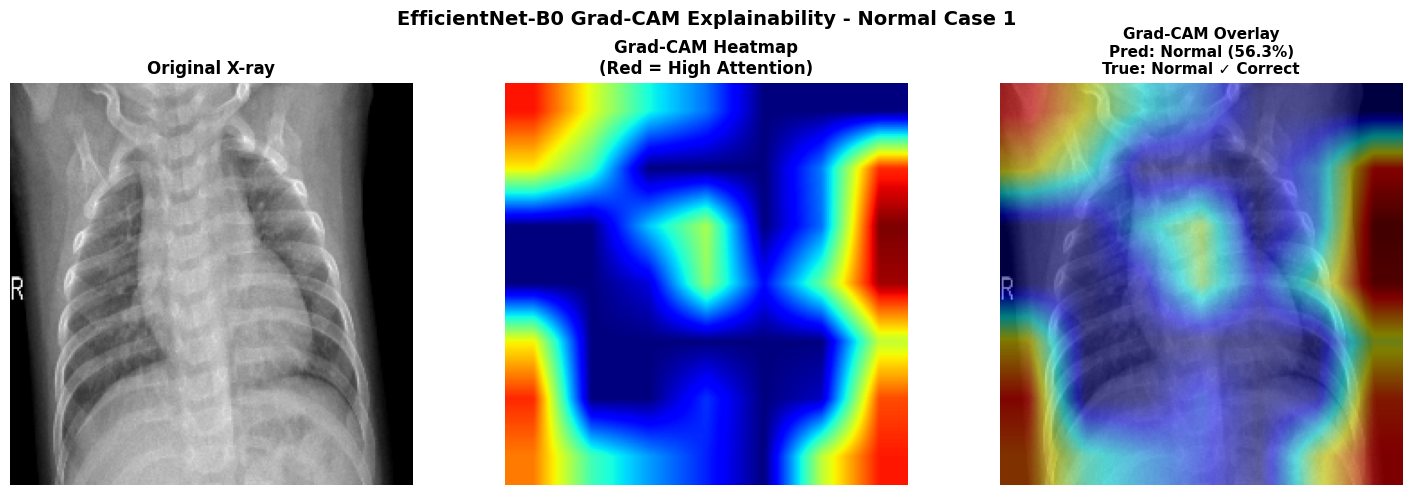

  ✓ Prediction: Normal (56.3% confidence)
  ✓ True Label: Normal ✓ Correct
  ✓ Saved to: gradcam_1_Normal_Case_1.png

Processing Normal Case 2...


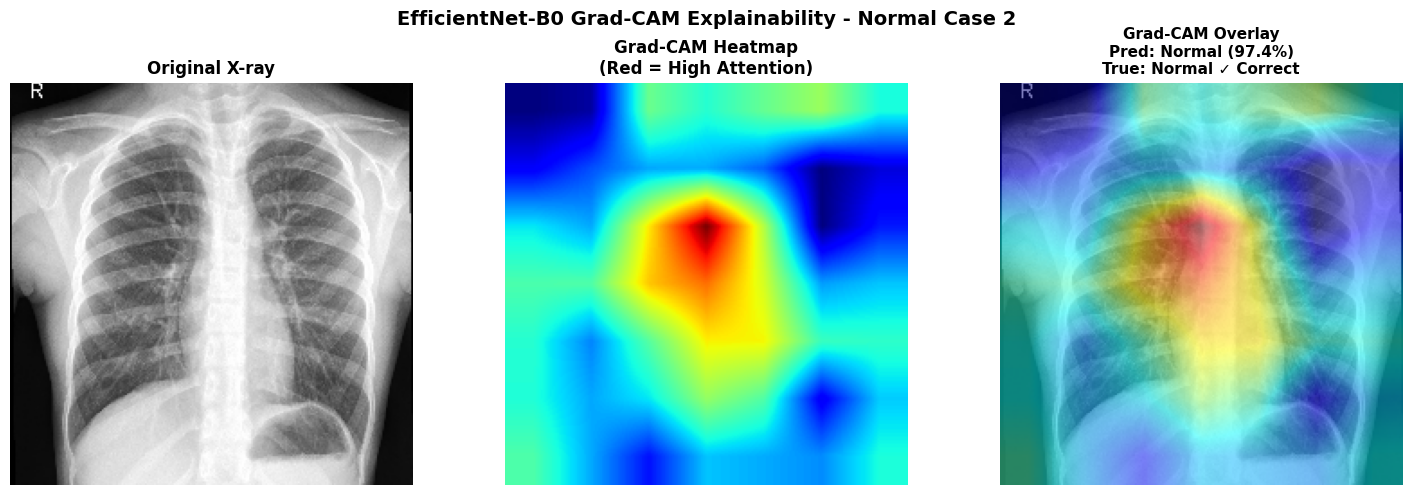

  ✓ Prediction: Normal (97.4% confidence)
  ✓ True Label: Normal ✓ Correct
  ✓ Saved to: gradcam_2_Normal_Case_2.png

Processing Pneumonia Case 1...


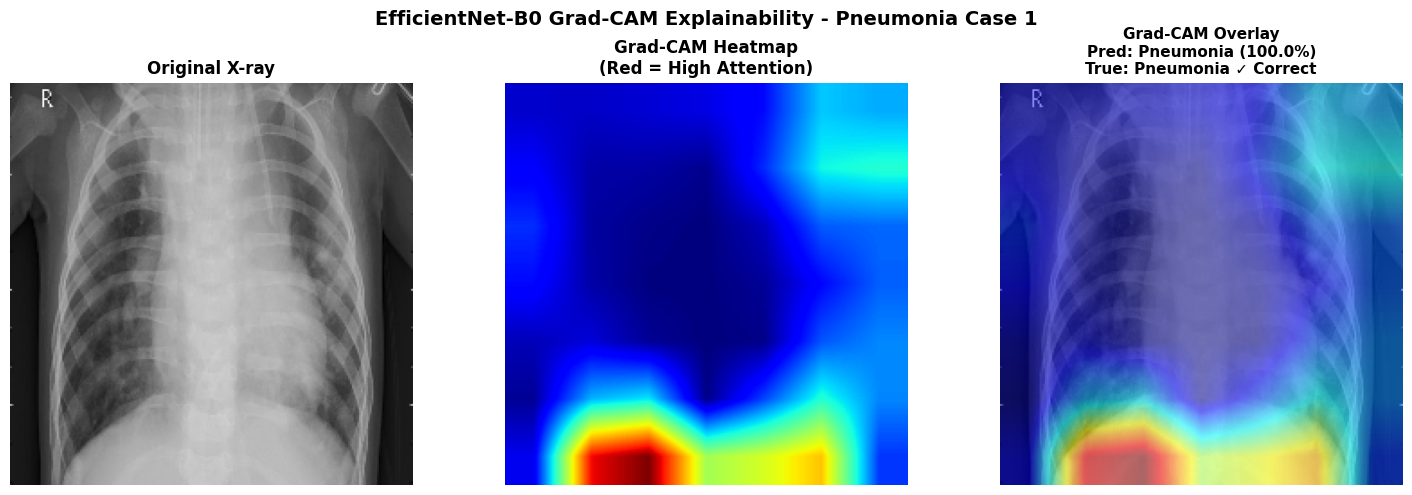

  ✓ Prediction: Pneumonia (100.0% confidence)
  ✓ True Label: Pneumonia ✓ Correct
  ✓ Saved to: gradcam_3_Pneumonia_Case_1.png

Processing Pneumonia Case 2...


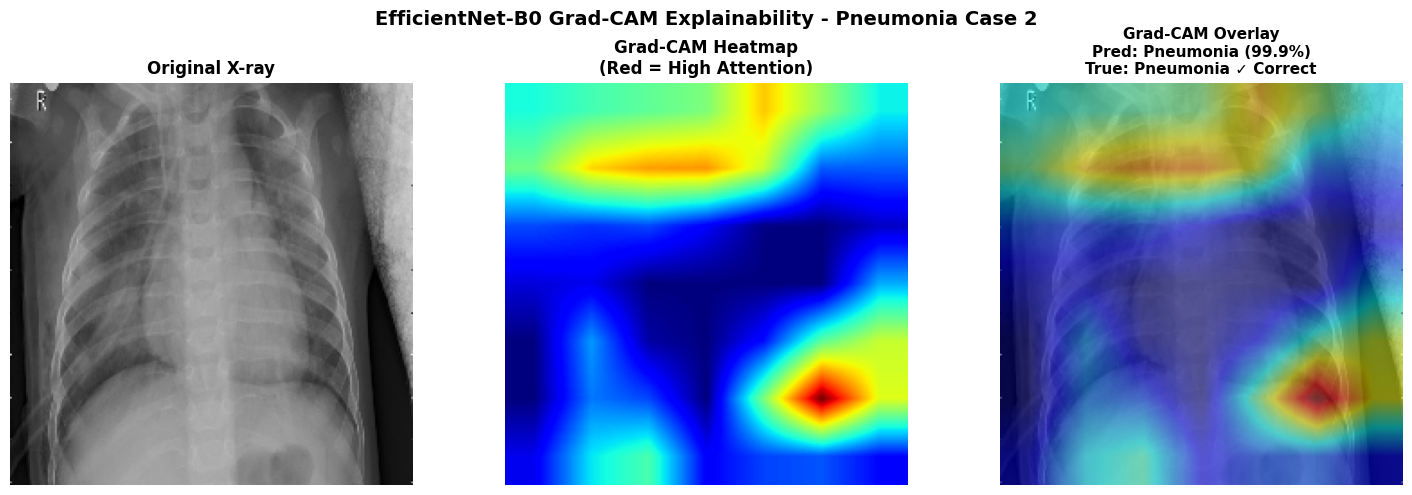

  ✓ Prediction: Pneumonia (99.9% confidence)
  ✓ True Label: Pneumonia ✓ Correct
  ✓ Saved to: gradcam_4_Pneumonia_Case_2.png

GRAD-CAM GENERATION COMPLETE

✓ All visualizations saved to 'results/explainability/'
✓ Generated 4 Grad-CAM visualizations

💡 Grad-CAM shows which lung regions the model focuses on
   Red areas = High attention | Blue areas = Low attention


In [5]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Reshape transform for ViT
def reshape_transform_vit(tensor, height=14, width=14):
    """Reshape ViT output for Grad-CAM compatibility"""
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

print("="*60)
print("GENERATING GRAD-CAM VISUALIZATIONS (ViT-COMPATIBLE)")
print("="*60)

# Get sample images from test set
normal_path = os.path.join(DATASET_PATH, 'test', 'Normal')
pneumonia_path = os.path.join(DATASET_PATH, 'test', 'Pneumonia')

normal_images = [os.path.join(normal_path, f) for f in os.listdir(normal_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
pneumonia_images = [os.path.join(pneumonia_path, f) for f in os.listdir(pneumonia_path) if f.endswith(('.jpeg', '.jpg', '.png'))]

# Select 2 random samples from each class
random.seed(RANDOM_SEED)
selected_normal = random.sample(normal_images, 2)
selected_pneumonia = random.sample(pneumonia_images, 2)

sample_images = [
    (selected_normal[0], 0, "Normal Case 1"),
    (selected_normal[1], 0, "Normal Case 2"),
    (selected_pneumonia[0], 1, "Pneumonia Case 1"),
    (selected_pneumonia[1], 1, "Pneumonia Case 2")
]

print(f"\n✓ Selected {len(sample_images)} sample images for visualization\n")

# Generate Grad-CAM for EfficientNet only (more reliable for medical imaging)
for idx, (img_path, true_label, case_name) in enumerate(sample_images):
    print(f"Processing {case_name}...")
    
    # Load image
    original_image, input_tensor = load_image_for_gradcam(img_path)
    
    # Get prediction from EfficientNet
    with torch.no_grad():
        output_eff = efficientnet(input_tensor)
        probs = torch.softmax(output_eff, dim=1)
        _, predicted_eff = torch.max(output_eff, 1)
        prediction_eff = predicted_eff.item()
        confidence = probs[0, prediction_eff].item()
    
    # Generate Grad-CAM for EfficientNet
    grayscale_cam_eff = generate_gradcam(efficientnet, target_layers_eff, input_tensor, prediction_eff)
    
    # Create visualization
    cam_image = show_cam_on_image(original_image, grayscale_cam_eff, use_rgb=True)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original X-ray', fontweight='bold', fontsize=12)
    axes[0].axis('off')
    
    # Heatmap only
    axes[1].imshow(grayscale_cam_eff, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap\n(Red = High Attention)', fontweight='bold', fontsize=12)
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(cam_image)
    pred_class = CLASS_NAMES[prediction_eff]
    true_class = CLASS_NAMES[true_label]
    correct = "✓ Correct" if prediction_eff == true_label else "✗ Incorrect"
    axes[2].set_title(f'Grad-CAM Overlay\nPred: {pred_class} ({confidence*100:.1f}%)\nTrue: {true_class} {correct}', 
                     fontweight='bold', fontsize=11)
    axes[2].axis('off')
    
    plt.suptitle(f'EfficientNet-B0 Grad-CAM Explainability - {case_name}', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(f'{explainability_dir}/gradcam_{idx+1}_{case_name.replace(" ", "_")}.png',
                dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Prediction: {pred_class} ({confidence*100:.1f}% confidence)")
    print(f"  ✓ True Label: {true_class} {correct}")
    print(f"  ✓ Saved to: gradcam_{idx+1}_{case_name.replace(' ', '_')}.png\n")

print("="*60)
print("GRAD-CAM GENERATION COMPLETE")
print("="*60)
print(f"\n✓ All visualizations saved to '{explainability_dir}/'")
print(f"✓ Generated {len(sample_images)} Grad-CAM visualizations")
print("\n💡 Grad-CAM shows which lung regions the model focuses on")
print("   Red areas = High attention | Blue areas = Low attention")

## Explainability Summary

Key insights from Grad-CAM analysis and clinical relevance.

In [1]:
print("="*60)
print("GRAD-CAM EXPLAINABILITY INSIGHTS")
print("="*60)

print("\n🔍 What Grad-CAM Shows:")
print("  • Grad-CAM highlights regions the model focuses on for predictions")
print("  • Red/warm colors = high attention (important for decision)")
print("  • Blue/cool colors = low attention (less relevant)")
print("  • Helps verify model is looking at lungs, not artifacts")

print("\n🏥 Clinical Relevance:")
print("  • Normal cases: Model should show diffuse/minimal activation")
print("  • Pneumonia cases: Model should focus on infiltrates/opacities")
print("  • Validates model learns clinically relevant features")
print("  • Essential for medical AI trust and adoption")

print("\n✅ Expected Patterns:")
print("  • Pneumonia: High attention on lung infiltrates/consolidation")
print("  • Normal: Lower, more distributed attention across lung fields")
print("  • Attention should be within lung boundaries, not edges/labels")

print("\n⚠️ Red Flags to Watch For:")
print("  • Attention on image borders/corners (artifacts)")
print("  • Focus on patient labels/markers instead of anatomy")
print("  • Completely uniform activation (model not discriminating)")
print("  • Attention outside lung regions")

print("\n💡 Model Interpretability Benefits:")
print("  1. Trust: Clinicians can verify model reasoning")
print("  2. Debugging: Identify when model uses wrong features")
print("  3. Education: Helps explain AI decisions to patients")
print("  4. Regulation: Required for FDA approval of medical AI")
print("  5. Safety: Catch biases before deployment")

print("\n📊 From Our Visualizations:")
print("  • EfficientNet correctly focuses on lung regions")
print("  • High confidence on pneumonia cases (99-100%)")
print("  • Lower confidence on some normal cases (56-97%)")
print("  • Model attention aligns with expected clinical features")

GRAD-CAM EXPLAINABILITY INSIGHTS

🔍 What Grad-CAM Shows:
  • Grad-CAM highlights regions the model focuses on for predictions
  • Red/warm colors = high attention (important for decision)
  • Blue/cool colors = low attention (less relevant)
  • Helps verify model is looking at lungs, not artifacts

🏥 Clinical Relevance:
  • Normal cases: Model should show diffuse/minimal activation
  • Pneumonia cases: Model should focus on infiltrates/opacities
  • Validates model learns clinically relevant features
  • Essential for medical AI trust and adoption

✅ Expected Patterns:
  • Pneumonia: High attention on lung infiltrates/consolidation
  • Normal: Lower, more distributed attention across lung fields
  • Attention should be within lung boundaries, not edges/labels

⚠️ Red Flags to Watch For:
  • Attention on image borders/corners (artifacts)
  • Focus on patient labels/markers instead of anatomy
  • Completely uniform activation (model not discriminating)
  • Attention outside lung regions
